In [37]:
import numpy as np
import pandas as pd
import time
import sklearn
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
%matplotlib inline


readdata = pd.read_csv("/home/dom/Documents/MPhys/TheGrandTour/wine_data.txt", sep="\t", header=None);
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
data_marker = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
        data_marker.append("x")
    elif classification[i] == 2:
        data_colour.append("b")
        data_marker.append("o")
    elif classification[i] == 3:
        data_colour.append("g")
        data_marker.append("*")
        
# Normalizes the data        
for i in range(0, np.shape(data)[0]):
    data[i,:] = (data[i,:] / np.ndarray.max(data[i,:])) * 2 - 1
    
        


#VARIABLES
stepSize = 0.01
nSteps = 10000

def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(1, 2, d, theta[1,2])
    i = 1
    j = 2
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==1 and j==2:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData, tBeta


tData, tBeta = GrandTour(data, nSteps)


In [5]:
targetData = np.zeros((len(tData[0][0]), 3))
for counter, i in enumerate(classification):
    targetData[counter][int(i-1)] = 1


In [7]:
import time

accuracy = []

start = time.clock()

init_op = tf.global_variables_initializer()


    
iterations = 1000

for i in range(iterations):

    if i % 10 == 0 and i != 0:
        current_time = time.clock() - start
        time_left = (float(current_time) / i) * (iterations - i)
        print("Time elapsed: " + str(current_time))
        print("Timestep: " + str(i) + " out of " + str(iterations))
        print("Approximately " + str(int(time_left)) + " seconds left")
        
    tf.reset_default_graph()

    xData = tData[i][0]
    yData = tData[i][1]
    trainingData = np.vstack((xData, yData)).T
    # NN model code
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    nnet = model.fit(trainingData, targetData, epochs=35, batch_size=1)
    accuracy.append(np.mean(nnet.history["acc"]))
    
x = list(range(0, len(accuracy)))

'for i in range(iterations):\n\n    if i % 10 == 0 and i != 0:\n        current_time = time.clock() - start\n        time_left = (float(current_time) / i) * (iterations - i)\n        print("Time elapsed: " + str(current_time))\n        print("Timestep: " + str(i) + " out of " + str(iterations))\n        print("Approximately " + str(int(time_left)) + " seconds left")\n        \n    tf.reset_default_graph()\n\n    xData = tData[i][0]\n    yData = tData[i][1]\n    trainingData = np.vstack((xData, yData)).T\n    # NN model code\n    model = tf.keras.models.Sequential()\n    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))\n    #model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))\n    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))\n\n    model.compile(optimizer=\'adam\',\n                 loss=\'categorical_crossentropy\',\n                 metrics=[\'accuracy\'])\n    nnet = model.fit(trainingData, targetData, epochs=35, batch_size=1)\n    accuracy.append(

max accuracy of: 0.9598715890850723, at timestep: 481


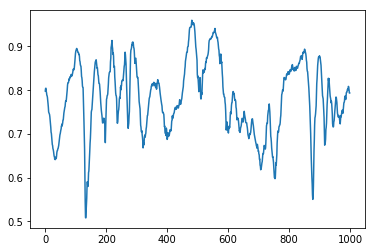

In [28]:
new = plt.figure()
plt.plot(x, accuracy, "-", marker="None")

max_accuracy = max(accuracy)
acc = max_accuracy
max_accuracy = [i for i, j in enumerate(accuracy) if j == max_accuracy]
max_accuracy = max_accuracy[0]
print("max accuracy of: " + str(acc) + ", at timestep: " + str(max_accuracy))

In [33]:
import pandas as pd 
df = pd.DataFrame(accuracy)
#df.to_csv("file_path.csv")
df.to_csv("/home/dom/Documents/MPhys/TheGrandTour/NNAcc.csv")

In [ ]:
tf.reset_default_graph()

# points that fill the space to show decision boundary
xy_points = []
for i in range(100):
    for j in range(100):
        x = (2 * i - 100) / 100
        y = (2 * j - 100) / 100
        xy_points.append([x, y])
        
print(len(xy_points))
xy_points = np.asarray(xy_points)
predictions = []


with tf.Session() as sess:
    xData = tData[484][0]
    yData = tData[484][1]
    trainingData = np.vstack((xData, yData)).T
    
    print(trainingData.shape)
    
    # NN model code
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    nnet = model.fit(trainingData, targetData, epochs=100)
    print(np.mean(nnet.history["acc"]))
    
    test = np.zeros((1,2))
    print(test.shape)

    predictions = model.predict(xy_points)
    

In [12]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

xy_points = []
for i in range(100):
    for j in range(100):
        x = (2 * i - 100) / 100
        y = (2 * j - 100) / 100
        xy_points.append([x, y])
        
xy_points = np.asarray(xy_points)

def plot_func(timestep):
    with tf.Session() as sess:
        # format input data
        xData = tData[int(timestep)][0]
        yData = tData[int(timestep)][1]
        trainingData = np.vstack((xData, yData)).T

        # NN model code
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
        #model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        batch_size = 1
        nnet = model.fit(trainingData, targetData, batch_size=batch_size, epochs=50, verbose=0)
        
        print("batch size: " + str(batch_size))
        print("accuracy measures on each epoch: " + str(nnet.history["acc"]))
        print("timestep: " + str(int(timestep)))
        print("accuracy: " + str((nnet.history["acc"][-1])))
        
        print("type: " + str(type(xy_points)))
        print(xy_points.shape)
        
        predictions = model.predict(xy_points)   
        predictionmax = []
        a = predictions.tolist()
        for i in range(len(a)):
            predictionmax.append(a[i].index(max(a[i])) + 1)
        
        data_colour = []
        for i in range(len(predictionmax)):
            if predictionmax[i] == 1:
                data_colour.append("r")
            elif predictionmax[i] == 2:
                data_colour.append("b")
            elif predictionmax[i] == 3:
                data_colour.append("g")
        
        x, y = zip(*xy_points)

        plt.figure(figsize=(12, 8))
        plt.scatter(x, y, color = data_colour)
        plt.show()
        
        
interact_manual(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = iterations - 1,
                                                   step = 1))

interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Button(description=…

<function __main__.plot_func(timestep)>

Contour version of ^

In [86]:
import matplotlib.lines as mlines


plt.close()
def plot_func(timestep):
    with tf.Session() as sess:
        # format input data
        xData = tData[int(timestep)][0]
        yData = tData[int(timestep)][1]
        trainingData = np.vstack((xData, yData)).T

        # NN model code
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        batch_size = 1
        nnet = model.fit(trainingData, targetData, batch_size=batch_size, epochs=50, verbose=0)
        
        print("batch size: " + str(batch_size))
        print("accuracy measures on each epoch: " + str(nnet.history["acc"]))
        print("timestep: " + str(int(timestep)))
        print("accuracy: " + str((nnet.history["acc"][-1])))
            
        # plot contours    
        x = np.arange(-1.5, 1.5, 0.01)
        y = np.arange(-1.5, 1.5, 0.01)
        xx, yy = np.meshgrid(x, y)
        
        xy = []
        for i in range(len(x)):
            for j in range(len(y)):
                #xy.append([x[i], y[j]])
                xy.append([y[j], x[i]]) # <- this way works 
        xy = np.array(xy)
                
        predictions = model.predict(xy)  
        predictionmax = []
        a = predictions.tolist()
        for i in range(len(a)):
            predictionmax.append(a[i].index(max(a[i])) + 1)

        z = np.reshape(predictionmax, (len(x),len(y)))
        
        plt.figure(figsize=(12, 8))

        plt.contourf(xx, yy, z, colors = ("r", "b", "g"), 
                     levels = 2)

        # plot data
        for i in range(len(xData)):
            formatted_data = [[xData[i], yData[i]]]
            prediction = model.predict(np.array(formatted_data))
            a = prediction.tolist()
            prediction = a[0].index(max(a[0])) + 1
            
            if int(prediction) == classification[i]:
                plt.scatter(xData[i], yData[i], color = 'black', marker = data_marker[i])
            else:
                plt.scatter(xData[i], yData[i], color = data_colour[i], marker = data_marker[i])
        blue_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle="")
        green_patch = mlines.Line2D([], [], color='green', marker='*', linestyle="")
        red_patch = mlines.Line2D([], [], color='red', marker='x', linestyle="")

        xmax, xmin = (max(xData) + 0.1, min(xData) - 0.1)
        ymax, ymin = (max(yData) + 0.1, min(yData) - 0.1)

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.legend(handles=[blue_patch, red_patch, green_patch])


        plt.show()
        
        
interact_manual(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = iterations - 1,
                                                   step = 1))

interactive(children=(FloatSlider(value=1.0, description='timestep', max=999.0, step=1.0), Button(description=…

<function __main__.plot_func(timestep)>

In [ ]:
tester = [[0, 0]]
tester = np.array(tester)
model.predict(tester)

In [15]:
np.asarray([1, 1]).reshape((1,2))

array([[1, 1]])

In [79]:
x = np.arange(0, 150, 1)
y = np.arange(0, 150, 1)
xx, yy = np.meshgrid(x, y)

xy = []
for i in range(len(x)):
    for j in range(len(y)):
        xy.append([str(x[i])+", "+str(y[j])])

xy = np.array(xy)




z = np.reshape(xy, (len(x), len(y)))


In [84]:
xc, yc = 149, 33

print("x=" + str(xc) + ", y=" + str(yc) + ", z=" + str(z[xc][yc]))

x=149, y=33, z=149, 33
